# **Churn Prediction: Final Refined Version**
This notebook implements data preprocessing, thorough EDA, and model evaluation for churn prediction using Random Forest and XGBoost.

## **Step 1: Import Libraries**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')


## **Step 2: Load and Inspect Data**

In [2]:

# Load dataset
data = pd.read_csv('BankChurners.csv')

# Drop CLIENTNUM and Naive Bayes classifier columns
data.drop(columns=['CLIENTNUM', 
                   'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                   'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
          inplace=True)

# Overview
print("Data Overview:")
display(data.head())
print("Shape of data:", data.shape)
print("Null Values:")
print(data.isnull().sum())


Data Overview:


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Shape of data: (10127, 20)
Null Values:
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [3]:
##Descriptive stats 

from scipy import stats

# Descriptive statistics using pandas
desc_stats = data.describe()
print("Descriptive Statistics (Pandas):")
display(desc_stats)

# Additional statistics using scipy
skewness = stats.skew(data.select_dtypes(include=['int64', 'float64']))
kurtosis = stats.kurtosis(data.select_dtypes(include=['int64', 'float64']))

additional_stats = pd.DataFrame({
    'Feature': data.select_dtypes(include=['int64', 'float64']).columns,
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

print("Additional Statistics (Scipy):")
display(additional_stats)

Descriptive Statistics (Pandas):


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


Additional Statistics (Scipy):


,Feature,Skewness,Kurtosis
0,Customer_Age,-0.033600,-0.289070
1,Dependent_count,-0.020822,-0.683272
2,Months_on_book,-0.106550,0.399310
3,Total_Relationship_Count,-0.162428,-1.006226
4,Months_Inactive_12_mon,0.632967,1.097388
5,Contacts_Count_12_mon,0.011004,0.000270
6,Credit_Limit,1.666479,1.807504
7,Total_Revolving_Bal,-0.148815,-1.146018
8,Avg_Open_To_Buy,1.661450,1.797137
9,Total_Amt_Chng_Q4_Q1,1.731807,9.987975


In [4]:


# Filter data for churned customers
churned_data = data[data['Attrition_Flag'] == 1]

# Descriptive statistics for churned customers
churned_desc_stats = churned_data.describe()
print("Descriptive Statistics for Churned Customers:")
display(churned_desc_stats)

# Additional statistics for churned customers using scipy
churned_skewness = stats.skew(churned_data.select_dtypes(include=['int64', 'float64']))
churned_kurtosis = stats.kurtosis(churned_data.select_dtypes(include=['int64', 'float64']))

churned_additional_stats = pd.DataFrame({
    'Feature': churned_data.select_dtypes(include=['int64', 'float64']).columns,
    'Skewness': churned_skewness,
    'Kurtosis': churned_kurtosis
})

print("Additional Statistics for Churned Customers (Scipy):")
display(churned_additional_stats)

data['Avg_Trans_value'] = data['Total_Trans_Amt']/data['Total_Trans_Ct']
data['Total_Chng_Q4_Q1'] = (data['Total_Amt_Chng_Q4_Q1']+ data['Total_Ct_Chng_Q4_Q1'])/2
data.replace([float('inf'), float('-inf')], 0, inplace=True)
data.fillna(0, inplace=True)
data.head()



Descriptive Statistics for Churned Customers:


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Additional Statistics for Churned Customers (Scipy):


C:\Users\Becode-son\AppData\Local\Temp\ipykernel_14716\4129962147.py:10: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  churned_skewness = stats.skew(churned_data.select_dtypes(include=['int64', 'float64']))
C:\Users\Becode-son\AppData\Local\Temp\ipykernel_14716\4129962147.py:11: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  churned_kurtosis = stats.kurtosis(churned_data.select_dtypes(include=['int64', 'float64']))


,Feature,Skewness,Kurtosis
0,Customer_Age,NaN,NaN
1,Dependent_count,NaN,NaN
2,Months_on_book,NaN,NaN
3,Total_Relationship_Count,NaN,NaN
4,Months_Inactive_12_mon,NaN,NaN
5,Contacts_Count_12_mon,NaN,NaN
6,Credit_Limit,NaN,NaN
7,Total_Revolving_Bal,NaN,NaN
8,Avg_Open_To_Buy,NaN,NaN
9,Total_Amt_Chng_Q4_Q1,NaN,NaN


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Avg_Trans_value,Total_Chng_Q4_Q1
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,27.238095,1.4800
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,39.121212,2.6275
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,94.350000,2.4635
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,58.550000,1.8690
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,29.142857,2.3375


## **Step 3: Encode Categorical Columns and Clean Data**

In [5]:


# Update Marital_Status to make divorced people single
data['Marital_Status'] = data['Marital_Status'].replace({'Divorced': 'Single'})

# Encode target variable and binary features
data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0})
data['Gender'] = data['Gender'].replace({'F': 1, 'M': 0})

# One-hot encode categorical features
categorical_cols = ['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category']
for col in categorical_cols:
    if 'Unknown' in data[col].unique():
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col).drop(columns='{}_Unknown'.format(col))], axis=1)
    else:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)



# Drop original categorical columns
data.drop(columns=categorical_cols, inplace=True)

print("Cleaned Data:")
display(data.head())
print("Updated Shape:", data.shape)


Cleaned Data:


C:\Users\Becode-son\AppData\Local\Temp\ipykernel_14716\715976529.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0})
C:\Users\Becode-son\AppData\Local\Temp\ipykernel_14716\715976529.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'] = data['Gender'].replace({'F': 1, 'M': 0})


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Marital_Status_Married,Marital_Status_Single,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,0,3,39,5,1,3,12691.0,777,...,False,True,False,False,True,False,True,False,False,False
1,0,49,1,5,44,6,1,2,8256.0,864,...,False,False,False,True,False,True,True,False,False,False
2,0,51,0,3,36,4,1,0,3418.0,0,...,False,False,True,False,True,False,True,False,False,False
3,0,40,1,4,34,3,4,1,3313.0,2517,...,False,False,False,True,False,False,True,False,False,False
4,0,40,0,3,21,5,1,0,4716.0,0,...,False,True,False,False,True,False,True,False,False,False


Updated Shape: (10127, 35)


## **Step 4: Exploratory Data Analysis**

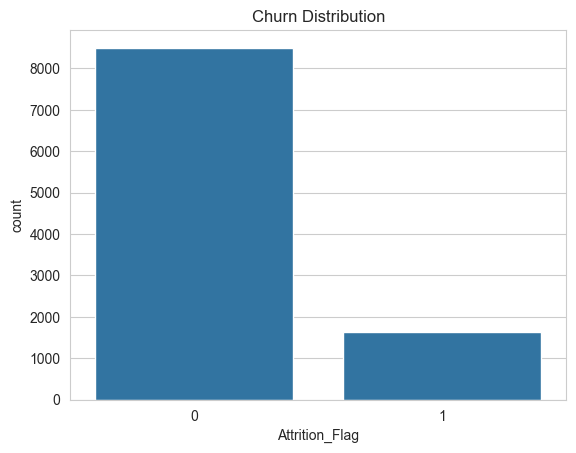

ValueError: num must be an integer with 1 <= num <= 16, not 17

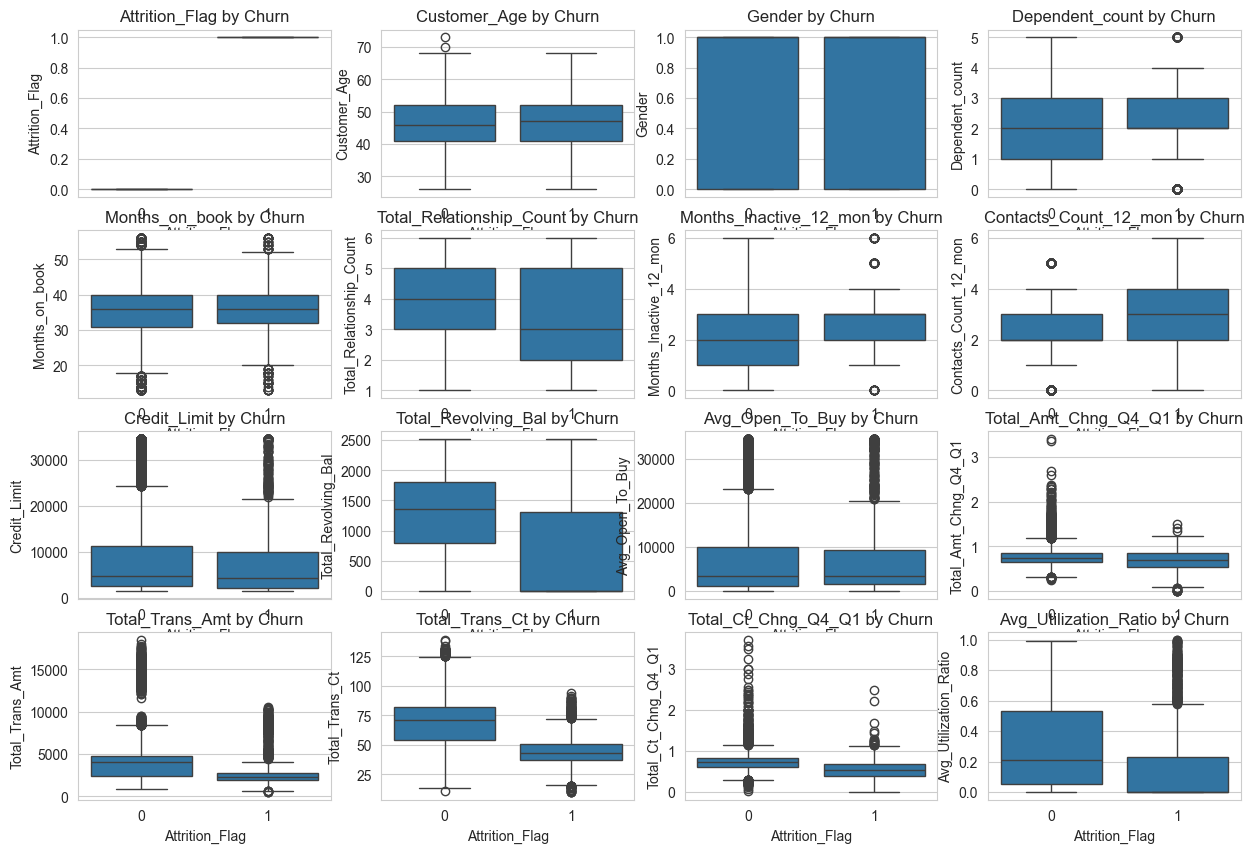

In [6]:

# Visualize class imbalance
sns.countplot(x='Attrition_Flag', data=data)
plt.title("Churn Distribution")
plt.show()

# Boxplots for numerical features to identify patterns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=data[col], x=data['Attrition_Flag'])
    plt.title(f"{col} by Churn")
plt.tight_layout()
plt.show()


## **Step 5: Train-Test Split and Class Balancing with SMOTE**

In [ ]:

# Split data
X = data.drop(columns=['Attrition_Flag'])
y = data['Attrition_Flag']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# SMOTE for imbalance handling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:")
print(y_train_res.value_counts())

# Train Random Forest with class weight balanced before SMOTE
rf_model_balanced_before_smote = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_model_balanced_before_smote.fit(X_train, y_train)

y_pred_rf_balanced_before_smote = rf_model_balanced_before_smote.predict(X_test)

print("Random Forest with Class Weight Balanced Before SMOTE Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_balanced_before_smote):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_balanced_before_smote):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_balanced_before_smote):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf_balanced_before_smote):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_balanced_before_smote))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_balanced_before_smote))


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

import pandas as pd

# 1. Split the data
X = data.drop(columns=['Attrition_Flag'])  # Features
y = data['Attrition_Flag']  # Target

# Stratified split to preserve class imbalance in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Train Random Forest with Class Weights ('balanced') on Unbalanced Data
rf_class_weight = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
)
rf_class_weight.fit(X_train, y_train)

# Predictions
y_pred_class_weight = rf_class_weight.predict(X_test)

# 3. Train Random Forest on SMOTE-Resampled Data
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_smote = rf_smote.predict(X_test)

# 4. Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred):.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

# 5. Evaluate Both Models
evaluate_model(y_test, y_pred_class_weight, "Random Forest with Class Weight")
evaluate_model(y_test, y_pred_smote, "Random Forest with SMOTE")


## **Step 6: Random Forest Model**

In [2]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

rf_model_balanced = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_model_balanced.fit(X_train_res, y_train_res)

y_pred_rf_balanced = rf_model_balanced.predict(X_test)

print("Random Forest with Class Weight Balanced Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_balanced):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_balanced):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_balanced):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf_balanced):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_balanced))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_balanced))

NameError: name 'RandomForestClassifier' is not defined

## **Step 7: XGBoost Model**

In [ ]:
from sklearn.model_selection import GridSearchCV


xgb_model = XGBClassifier(scale_pos_weight=6, n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print("Classification Report:", classification_report(y_test, y_pred_xgb))

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 3, 5, 7]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
xgb_best = XGBClassifier(**best_params, random_state=42)
xgb_best.fit(X_train_res, y_train_res)

# Predictions
y_pred_xgb_best = xgb_best.predict(X_test)

# Evaluation
print("XGBoost Best Model Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_best):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb_best):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb_best):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb_best):.2f}")
print("Classification Report:", classification_report(y_test, y_pred_xgb_best))

## **Step 8: Feature Importance**

In [ ]:

importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Feature Importances")
plt.show()


## **Best XGB Model Parameters


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# After GridSearchCV, you already have the best parameters:
best_params = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 7}

# Train the best model with the best parameters
xgb_best = XGBClassifier(**best_params, random_state=42)
xgb_best.fit(X_train_res, y_train_res)

# Make predictions with the best model
y_pred_xgb_best = xgb_best.predict(X_test)

# 1. **Confusion Matrix**
conf_matrix = confusion_matrix(y_test, y_pred_xgb_best)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Existing", "Attrited"], yticklabels=["Existing", "Attrited"])
plt.title("Confusion Matrix - XGBoost Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. **Classification Report (Text)**

# Generate the classification report for the best model
report = classification_report(y_test, y_pred_xgb_best, target_names=["Existing", "Attrited"], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 3. **Plotting Classification Report Metrics (Bar Chart)**

report_df.drop(columns=['support'], inplace=True)  # Drop 'support' column for the bar chart
report_df.plot(kind='bar', figsize=(10, 6))

plt.title("Classification Report - XGBoost Best Model")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.show()

# 4. **Model Performance Comparison (Accuracy, Precision, Recall, F1 Score)**

# Accuracy, Precision, Recall, and F1 Score for the best model
accuracy = accuracy_score(y_test, y_pred_xgb_best)
precision = precision_score(y_test, y_pred_xgb_best)
recall = recall_score(y_test, y_pred_xgb_best)
f1 = f1_score(y_test, y_pred_xgb_best)

# Bar plot for model comparison (Only one model here, you can add more if you have others)
models = ['XGBoost Best Model']
accuracy_scores = [accuracy]
precision_scores = [precision]
recall_scores = [recall]
f1_scores = [f1]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.2
plt.bar(x - width, accuracy_scores, width, label='Accuracy')
plt.bar(x, precision_scores, width, label='Precision')
plt.bar(x + width, recall_scores, width, label='Recall')
plt.bar(x + 2 * width, f1_scores, width, label='F1 Score')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()


NameError: name 'X_train_res' is not defined